### Choosing Target Systems

importing the things:

In [1]:
import etta #wrapper for downloading info from exofop
import pandas as pd
from pathlib import Path
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

**Every TOI is saved in a different sub-folder within the data directory saved below**

The location of my files, I use capital letters to show that this is a fixed variable.

In [2]:
DATA_DIR = '/srv/scratch/astro/z5345592/data/tess_tois/'

Using the exofop wrapper 'etta' to download the up to date listing of all TESS TOIs along with their metadata and assign it to a pandas dataframe:

In [3]:
exofop_toi_df = etta.download_toi(sort='toi') #download the TESS TOI info and assign to a dataframe

Fetching data from https://exofop.ipac.caltech.edu/tess/download_toi.php?output=pipe&sort=toi


### Functions

**get_num_obs returns the number of observations for a TOI.**

It checks a folder for files that end with the string that identifies a file as a HARPS 2D specrum file, assumes that this means that this corresponds to an observation and then adds 1 to a count.

In [4]:
def get_num_obs(toi_path):
    num_observations = 0 #initialise the count
    for path in toi_path.rglob('*e2ds_A.fits'): #e2ds_A.fits is the suffix that shows that a file is a HARPS 2D spectrum.
        if path.is_file:
                num_observations += 1 #add one to the count
    return num_observations

**get_baseline returns the number of days between the first and last observation in a folder.**

In [5]:
def get_baseline(toi_path):
    all_obs_dates = [] #initialise an empty list for dates.
    for path in toi_path.rglob('*e2ds_A.fits'): #loop through the 2D spectrum files.
            sp = fits.open(path) #open the spectrum fits file
            obs_date = sp[0].header['MJD-OBS'] #grab the observation date from the files header metadata
            all_obs_dates.append(obs_date) #append the date to the empty list.
    baseline = int(max(all_obs_dates) - min(all_obs_dates)) #calculate the baseline as the difference between the max and minimum dates.
    return baseline

Initialising some empty lists so I can get the values for every TOI I have data for.

In [6]:
all_toi_names = []
all_num_observations = []
all_baselines = []

This loop goes through all the TOI directories, gets the TOI name, the number of observations and baseline (using the functions above) and then appends them to the lists initialised directly above.

**WARNING - this can take a reasonably long time to run if you have a lot of TOIs about 15 minutes or more**

In [7]:
for dir in Path(DATA_DIR).iterdir():
    if dir.is_dir:
        toi_name = str(dir.name)
        num_obs = get_num_obs(dir)
        if num_obs == 0:
            baseline = 0
        else:
            baseline = get_baseline(dir)
        all_toi_names.append(toi_name)
        all_num_observations.append(num_obs)
        all_baselines.append(baseline)

Turning those 3 lists into a dataframe for the info about the spectroscopic data I have for TESS TOIs:

In [8]:
tois_spec_info = pd.DataFrame({'Names': all_toi_names, 'No. Observations': all_num_observations, 'Baseline (days)': all_baselines})

Need to change how the names are formatted from my data folders so they can match with the TESS format.

In [9]:
tois_spec_info['Names'] = tois_spec_info['Names'].str.replace('_', '.') #replace the underline with a decimal point
tois_spec_info['Names'] = tois_spec_info['Names'].astype(float) #change it to a float - this is so the indexing works correctly with pandas

Picking the columns from the exofop table I want, and then slicing the exofop table rowwise with the TOIs I have spectroscopic information for.

In [10]:
exofop_toi_df = exofop_toi_df[['Stellar Eff Temp (K)','Stellar Mass (M_Sun)', 'Stellar Radius (R_Sun)', 'Period (days)', 'Duration (hours)', 'Depth (ppm)', 'Planet Radius (R_Earth)', 'Comments']]
exofop_toi_df = exofop_toi_df.loc[tois_spec_info['Names'].values]

Sorting both tables by their TOI number so I can concatenate them.

In [11]:
tois_spec_info = tois_spec_info.sort_values('Names')
exofop_toi_df = exofop_toi_df.sort_index()

In [12]:
tois_spec_info.set_index('Names') #changing the index to the TOI name

,No. Observations,Baseline (days)
Names,,
102.01,38,1567
107.01,68,8
116.01,0,0
117.01,8,168
118.01,39,39
...,...,...
5116.01,4,1
5141.01,29,53
5144.01,27,53


Creating a new table of all the information by concatenating both tables together, setting the index to TOI name.

In [13]:
toi_data_info = pd.concat([tois_spec_info.reset_index(drop=True),exofop_toi_df.reset_index(drop=True)], axis=1)

In [14]:
toi_data_info

,Names,No. Observations,Baseline (days),Stellar Eff Temp (K),Stellar Mass (M_Sun),Stellar Radius (R_Sun),Period (days),Duration (hours),Depth (ppm),Planet Radius (R_Earth),Comments
0,102.01,38,1567,6280.0,1.280000,1.210000,4.411929,3.894000,14790.000000,15.202300,WASP 62 b
1,107.01,68,8,6153.0,1.140000,1.710360,3.950201,4.564364,12813.762931,19.705896,WASP-94 A b
2,116.01,0,0,4920.0,0.810000,0.906655,2.798579,2.340144,16701.550251,11.764075,WASP-91 b
3,117.01,8,168,5704.8,1.020000,2.004410,3.586296,3.371094,5729.324686,16.474761,HATS-68 b
4,118.01,39,39,5586.0,0.970000,1.051680,6.034457,2.207450,1575.374221,4.764396,HD 219666 b
...,...,...,...,...,...,...,...,...,...,...,...
422,5116.01,4,1,4870.0,0.790000,0.800000,3.435508,2.383000,2580.000000,4.494870,NaN
423,5141.01,29,53,5609.0,0.992000,1.785980,11.818606,5.532433,1479.837180,6.914241,HD 89345 b
424,5144.01,27,53,5817.3,NaN,NaN,2.655709,2.612319,20260.272496,NaN,WASP-85 A b; SPOC assuming solar radius but Rs...
425,5145.01,78,327,5322.0,0.920000,0.840476,7.918875,3.155689,5994.292449,6.498615,K2-19 b


Plotting by some common parameters to get an idea of what my sample looks like.

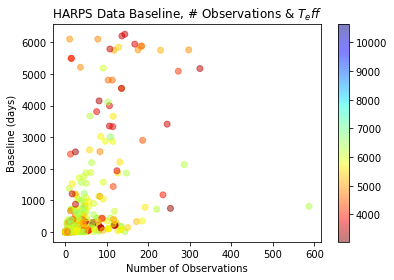

In [15]:
x = toi_data_info['No. Observations']
y = toi_data_info['Baseline (days)']
z = toi_data_info['Stellar Eff Temp (K)']

plt.scatter(x, y, c=z, alpha=0.5, cmap='jet_r')
plt.xlabel('Number of Observations')
plt.ylabel('Baseline (days)')
plt.title('HARPS Data Baseline, # Observations & $T_eff$')
plt.colorbar()

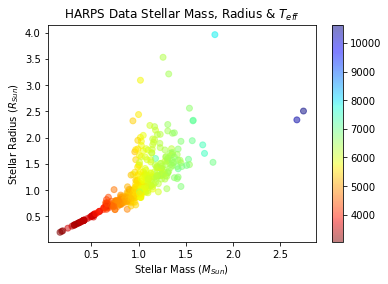

In [16]:
x = toi_data_info['Stellar Mass (M_Sun)']
y = toi_data_info['Stellar Radius (R_Sun)']
z = toi_data_info['Stellar Eff Temp (K)']

plt.scatter(x, y, c=z, alpha=0.5, cmap='jet_r')
plt.xlabel('Stellar Mass ($M_{Sun}$)')
plt.ylabel('Stellar Radius ($R_{Sun}$)')
plt.title('HARPS Data Stellar Mass, Radius & $T_{eff}$')
plt.colorbar()

Text(0.5, 0, '$T_{eff}$')

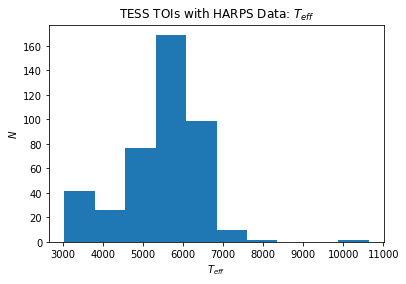

In [17]:
plt.hist(toi_data_info['Stellar Eff Temp (K)'])
plt.title('TESS TOIs with HARPS Data: $T_{eff}$')
plt.ylabel('$N$')
plt.xlabel('$T_{eff}$')

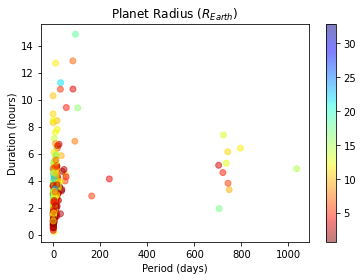

In [18]:
x = toi_data_info['Period (days)']
y = toi_data_info['Duration (hours)']
z = toi_data_info['Planet Radius (R_Earth)']

plt.scatter(x, y, c=z, alpha=0.5, cmap='jet_r')
plt.xlabel('Period (days)')
plt.ylabel('Duration (hours)')
plt.title('Planet Radius ($R_{Earth}$)')
plt.colorbar()

Filtering my sample of stars by those that are below the Kraft Break, $T_{eff} = 6250K$ but above M Dwarfs, $T_{eff}>3500K$. I also want to have more than 10 observations across a baseline of more than a week.

In [19]:
toi_data_info_subset = toi_data_info[(toi_data_info['Stellar Eff Temp (K)'] < 6250) & (toi_data_info['Stellar Eff Temp (K)'] > 3500) & (toi_data_info['No. Observations'] > 10) & (toi_data_info['Baseline (days)'] > 7)]

In [20]:
toi_data_info_subset.sort_values('Period (days)', ascending=False)

,Names,No. Observations,Baseline (days),Stellar Eff Temp (K),Stellar Mass (M_Sun),Stellar Radius (R_Sun),Period (days),Duration (hours),Depth (ppm),Planet Radius (R_Earth),Comments
309,2008.01,14,71,5463.00,0.992000,1.947710,723.834501,7.382946,3119.298369,13.136170,former single transit; now has second transit ...
39,224.01,16,20,3689.00,0.522000,0.487000,705.584466,1.918921,101204.845994,17.179547,actual period likely shorter than 705.58 days;...
390,4507.01,29,419,6115.26,1.150000,1.975850,104.615941,9.391587,6371.394816,16.198533,large PC
278,1338.01,56,972,5723.20,1.020000,3.092540,95.200000,14.844805,2512.311420,18.003841,period confirmed 95.2 days (Veselin B. Kostov ...
388,4409.01,14,342,4930.50,0.810000,0.732008,92.487606,6.916421,11324.901182,7.790122,NaN
...,...,...,...,...,...,...,...,...,...,...,...
384,4326.01,28,11,6034.49,1.120000,1.079030,0.000000,3.636796,420.129212,2.256842,single transit; possible L1 planet
38,222.01,29,725,5709.00,1.020000,1.092900,0.000000,0.680000,5530.000000,8.858690,single transit (no period)
316,2221.01,136,6203,3588.00,0.662074,0.698009,0.000000,3.573801,2872.288753,4.026926,AU Mic b; first transit matches expected ephem...
91,429.01,28,447,5216.00,0.890000,0.950000,0.000000,10.283000,8988.000000,10.281400,TOI 429; single transit with unknown period


Text(0.5, 0, '$T_{eff}$')

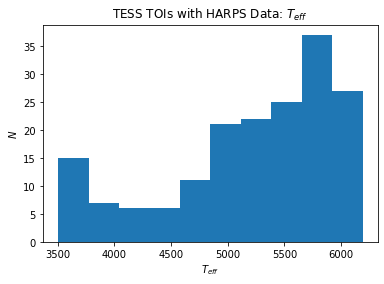

In [21]:
plt.hist(toi_data_info_subset['Stellar Eff Temp (K)'])
plt.title('TESS TOIs with HARPS Data: $T_{eff}$')
plt.ylabel('$N$')
plt.xlabel('$T_{eff}$')

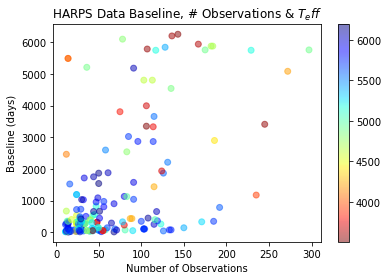

In [22]:
x = toi_data_info_subset['No. Observations']
y = toi_data_info_subset['Baseline (days)']
z = toi_data_info_subset['Stellar Eff Temp (K)']

plt.scatter(x, y, c=z, alpha=0.5, cmap='jet_r')
plt.xlabel('Number of Observations')
plt.ylabel('Baseline (days)')
plt.title('HARPS Data Baseline, # Observations & $T_eff$')
plt.colorbar()

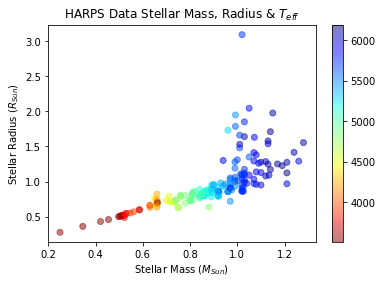

In [23]:
x = toi_data_info_subset['Stellar Mass (M_Sun)']
y = toi_data_info_subset['Stellar Radius (R_Sun)']
z = toi_data_info_subset['Stellar Eff Temp (K)']

plt.scatter(x, y, c=z, alpha=0.5, cmap='jet_r')
plt.xlabel('Stellar Mass ($M_{Sun}$)')
plt.ylabel('Stellar Radius ($R_{Sun}$)')
plt.title('HARPS Data Stellar Mass, Radius & $T_{eff}$')
plt.colorbar()

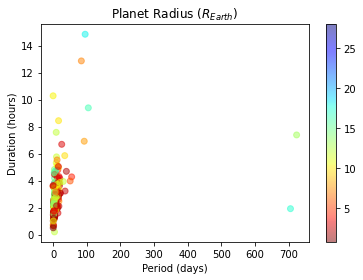

In [24]:
x = toi_data_info_subset['Period (days)']
y = toi_data_info_subset['Duration (hours)']
z = toi_data_info_subset['Planet Radius (R_Earth)']

plt.scatter(x, y, c=z, alpha=0.5, cmap='jet_r')
plt.xlabel('Period (days)')
plt.ylabel('Duration (hours)')
plt.title('Planet Radius ($R_{Earth}$)')
plt.colorbar()

Both the transits that have periods over 700 days I don't have enough data to be able to detect that periodicity I don't think (15 observations over 20 and 71 days), so going to knock them out of my sample.

In [25]:
t_eff_high = (toi_data_info['Stellar Eff Temp (K)'] < 6250)
t_eff_low = (toi_data_info['Stellar Eff Temp (K)'] > 3500)
n_obs_min = (toi_data_info['No. Observations'] > 100)
baseline_min = (toi_data_info['Baseline (days)'] > 7)
period_max = (toi_data_info['Period (days)'] < 500)

toi_data_info_subset = toi_data_info[t_eff_high & t_eff_low & n_obs_min & baseline_min & period_max]

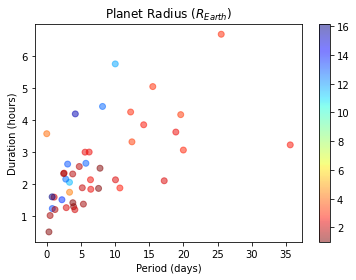

In [26]:
x = toi_data_info_subset['Period (days)']
y = toi_data_info_subset['Duration (hours)']
z = toi_data_info_subset['Planet Radius (R_Earth)']

plt.scatter(x, y, c=z, alpha=0.5, cmap='jet_r')
plt.xlabel('Period (days)')
plt.ylabel('Duration (hours)')
plt.title('Planet Radius ($R_{Earth}$)')
plt.colorbar()

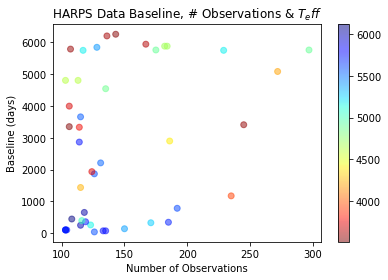

In [27]:
x = toi_data_info_subset['No. Observations']
y = toi_data_info_subset['Baseline (days)']
z = toi_data_info_subset['Stellar Eff Temp (K)']

plt.scatter(x, y, c=z, alpha=0.5, cmap='jet_r')
plt.xlabel('Number of Observations')
plt.ylabel('Baseline (days)')
plt.title('HARPS Data Baseline, # Observations & $T_eff$')
plt.colorbar()

In [28]:
toi_data_info_subset.sort_values('Names', ascending=False)

,Names,No. Observations,Baseline (days),Stellar Eff Temp (K),Stellar Mass (M_Sun),Stellar Radius (R_Sun),Period (days),Duration (hours),Depth (ppm),Planet Radius (R_Earth),Comments
426,5146.01,235,1173,3920.00,0.546024,0.550856,10.054178,2.130798,1566.736010,2.199909,K2-3 b
419,5094.01,245,3410,3552.00,0.497757,0.500000,3.336773,1.741000,6490.000000,4.309570,GJ 3470 b
392,4517.01,272,5085,4199.00,0.660000,0.634163,1.208912,1.199354,672.151721,1.621871,GJ 9827 b
389,4470.01,116,395,5023.00,0.840000,0.780000,2.218571,1.507000,26650.000000,13.532700,HD 189733 b
316,2221.01,136,6203,3588.00,0.662074,0.698009,0.000000,3.573801,2872.288753,4.026926,AU Mic b; first transit matches expected ephem...
291,1905.01,115,1436,4233.20,0.660000,0.730000,5.722260,2.648000,25549.000000,12.843300,WASP-107 b
277,1233.04,103,101,5723.87,1.020000,0.900854,3.795304,2.312993,321.974855,1.671342,NaN
276,1233.03,103,101,5723.87,1.020000,0.864173,6.202987,2.999448,697.849132,2.461556,HD 108236 c / TOI 1233.03
275,1233.02,104,101,5723.87,1.020000,0.864173,19.593213,4.171042,1161.276700,3.215833,HD 108236 e/TOI 1233.02
274,1233.01,103,101,5723.87,1.020000,0.864173,14.178442,3.853585,846.369675,2.629942,HD 108236 d / TOI-1233.01


I have had a problem before of there being a big gap between observations, going to see if there is a way that I can figure this out. Maybe my the median difference between? Testing this on 5094_01

In [83]:
TOI_NAME = '5094_01'
TEST_FILE = '/srv/scratch/astro/z5345592/data/tess_tois/5094_01/HARPS.2008-12-26T06:34:50.163_ccf_M2_A.fits'
path = Path(DATA_DIR) / TOI_NAME

In [178]:
dates = []
rvs_pipeline = []
rvs_pipeline_err = []

for ccf in path.rglob('*ccf_M2_A.fits*'):
    f = fits.open(ccf)
    date = f[0].header['HIERARCH ESO DRS BJD']
    rv = f[0].header['HIERARCH ESO DRS CCF RVC'] * 1.e3
    rv_err = f[0].header['HIERARCH ESO DRS CCF NOISE'] * 1.e3
    dates.append(date)
    rvs_pipeline.append(rv)
    rvs_pipeline_err.append(rv_err)

dates_sorted = np.sort(dates)
dates_diff = np.diff(dates_sorted)
med_date_diff = np.median(dates_diff)

In [211]:
import pyvo as vo

In [217]:
tap_service = vo.dal.TAPService("https://exoplanetarchive.ipac.caltech.edu/TAP")
tap_results = tap_service.search("SELECT tic_id, pl_name,pl_bmasse,ra,dec FROM pscomppars")

In [223]:
pd.DataFrame(tap_results).sort_values('pl_bmasse')

,dec,pl_bmasse,pl_name,ra,tic_id
3632,12.682353,0.0200,PSR B1257+12 b,195.014903,
1238,44.518373,0.0275,Kepler-37 e,284.059250,TIC 164652245
2432,41.631884,0.0374,Kepler-444 b,289.752832,TIC 394172596
2256,43.293064,0.0660,Kepler-138 b,290.381412,TIC 159376971
2433,41.631884,0.0793,Kepler-444 c,289.752832,TIC 394172596
...,...,...,...,...,...
3443,41.396090,NaN,Kepler-699 b,296.888153,TIC 168811723
3533,45.578842,NaN,Kepler-730 b,285.554790,TIC 352013543
3753,-6.378954,NaN,K2-253 b,186.085306,TIC 98669309
3952,46.984449,NaN,KIC 10001893 d,287.389231,TIC 158488181
